Read the dataset

In [2]:
import pandas as pd

df = pd.read_csv('b.csv')

Clean the data

In [3]:
categoryCol=['substrict','type','direction']
for i in categoryCol:
    df[i]=df[i].astype("category")

In [4]:
df['time'] = pd.to_datetime(df['time'], format='%Y.%m.%d')

for i in range(len(df)):
    if df.loc[i,'time'] < pd.Timestamp(2011, 1, 1):
        df.loc[i,'time']=pd.Timestamp(2011, 1, 1)

In [5]:
def cleanMinus(data):
    data=str(data)
    if data.find('-')==-1:
        return data
    data=data.split('-')
    return data[0]

In [6]:
def cleanColMinus(df,colName):
    for i in range(len(df)):
        df.loc[i,colName]=cleanMinus(df.loc[i,colName])

In [7]:
minusCols=['price','price per m2']
for i in minusCols:
    cleanColMinus(df,i)
    df[i]=df[i].astype('float64')

Finish the data cleaning

In [17]:
df.index=df.time

<AxesSubplot:xlabel='time'>

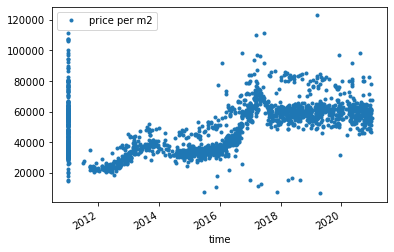

In [18]:
df.plot(x="time", y=["price per m2"], style='.')

<AxesSubplot:xlabel='time'>

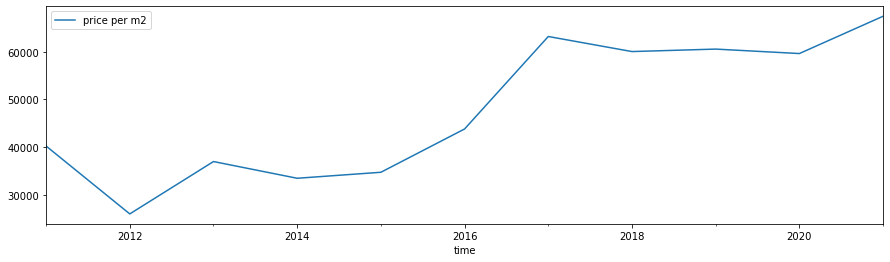

In [24]:
df[["price per m2"]].resample("1y").median().plot(figsize=(15,4))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

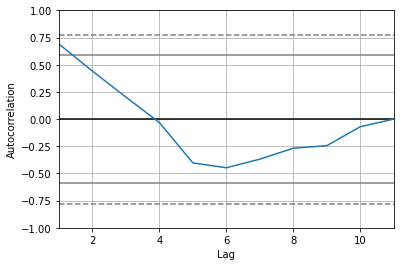

In [26]:
pd.plotting.autocorrelation_plot(df["price per m2"].resample("1y").median())

In [29]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)